In [45]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
%matplotlib inline

from collections import Counter

In [46]:
# Load training and test sets (assumes you have these in current working directory)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [47]:
# Inspect training set
# train.head()

In [48]:
# Inspect test set
# test.head()

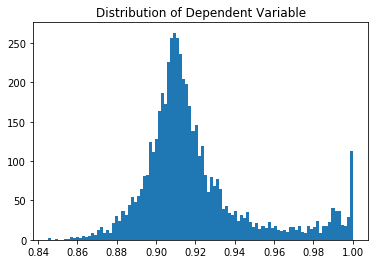

In [49]:
# Explore distribution of target
plt.hist(train['Target'], bins = 100)
plt.title("Distribution of Dependent Variable")
plt.show()

In [50]:
# Split training set into X and y (removing first column containing IDs)
X_train = train.iloc[:, 1:-1]
y_train = train.iloc[:, -1]

In [51]:
# Define function to compute RMSE
def scoreRMSE(predictor, X, true_y):
    predictions = predictor.predict(X)
    return np.sqrt(mean_squared_error(predictions, true_y))

In [52]:
# Define function to return labels of features not meeting a certain threshold
# Threshold can be on a mean or a standard deviation.
def get_bad_features(df, thresh, type='std'):
    bads = []
    if type == 'std':
        summaries = df.std()
    elif type == 'mean':
        summaries = df.mean()
    for label, summary in summaries.iteritems():
        if summary < thresh:
            bads += [label]
    return bads

In [69]:
# Calculate bad features
thresh = 0.02
bad_features = get_bad_features(X_train, thresh, type='std')

print(len(bad_features),f'features that have sd below {thresh}')
for f in bad_features:
    print(f)


70 features that have sd below 0.02
Feat 1
Feat 3
Feat 4
Feat 18
Feat 21
Feat 22
Feat 23
Feat 24
Feat 25
Feat 26
Feat 27
Feat 28
Feat 40
Feat 41
Feat 43
Feat 44
Feat 46
Feat 48
Feat 50
Feat 52
Feat 54
Feat 67
Feat 72
Feat 75
Feat 77
Feat 80
Feat 86
Feat 88
Feat 93
Feat 94
Feat 95
Feat 100
Feat 106
Feat 107
Feat 108
Feat 109
Feat 111
Feat 112
Feat 115
Feat 117
Feat 118
Feat 122
Feat 143
Feat 145
Feat 170
Feat 187
Feat 188
Feat 189
Feat 190
Feat 202
Feat 204
Feat 205
Feat 207
Feat 217
Feat 221
Feat 222
Feat 223
Feat 225
Feat 226
Feat 227
Feat 228
Feat 229
Feat 230
Feat 236
Feat 237
Feat 238
Feat 239
Feat 240
Feat 244
Feat 245


In [70]:
# Remove bad features
X_train = X_train.drop(columns=bad_features)

In [71]:
# Fit unregularized linear regression and see RMSE on training set
linReg = Lin_Reg()
linReg.fit(X_train, y_train)

print("Training RMSE: ", scoreRMSE(linReg, X_train, y_train))

Training RMSE:  0.02646250607235033


In [72]:
# Remove first column to make predictions
X_test = test.iloc[:, 1:]
# Drop bad features
X_test = X_test.drop(columns=bad_features)
X_test.head()

,Feat 2,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,Feat 10,Feat 11,Feat 12,Feat 13,...,Feat 235,Feat 241,Feat 242,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251
0,0.174118,0.133333,0.2,0.0,0.0,0.000000,0.000000,0.0,0.230769,0.409091,...,0.0,0.0,0.0,0.0,0.728471,0.054397,0.649,0.416164,0.053998,0.667391
1,0.164706,0.066667,0.0,0.0,0.0,0.000000,0.000000,0.1,0.096154,0.045455,...,0.0,0.0,0.0,0.0,0.497255,0.037736,0.375,0.165514,0.101973,0.506650
2,0.174118,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.211538,0.181818,...,0.0,0.0,0.0,0.0,0.688941,0.019309,1.000,0.192069,0.120700,0.498784
3,0.174118,0.133333,0.0,0.0,0.0,0.363636,0.166667,0.2,0.211538,0.181818,...,0.0,0.0,0.0,0.0,0.654118,0.019089,0.333,0.451252,0.164180,0.774466
4,0.164706,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.153846,0.181818,...,0.0,0.0,0.0,0.0,0.627451,0.160433,0.882,0.147407,0.000000,0.481240


In [73]:
# Make predictions using linear regression model fitted above
predictions = linReg.predict(X_test)

In [74]:
# Format predictions to be compatible with Kaggle upload
sample_submission = pd.DataFrame(data=predictions, columns=['Predicted'])
sample_submission.insert(0, "Id", range(1, 1 + X_test.shape[0]))
sample_submission['Id'] = sample_submission['Id'].astype(str)
sample_submission.head()

,Id,Predicted
0,1,0.933925
1,2,0.916260
2,3,0.922107
3,4,0.933777
4,5,0.925812


In [75]:
# Save predictions to .csv file for upload to Kaggle
sample_submission.to_csv("submission1.csv", index=False)

In [76]:
# Random Forest Regression Model

print("performing grid search")
# Perform Grid-Search
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(7, 11),
        'n_estimators': (100, 1000),
    },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
print("grid result")
grid_result = gsc.fit(X_train, y_train)


performing grid search
grid result


In [77]:
print("rfr")
rfr = RandomForestRegressor(max_depth=gsc.best_params_["max_depth"], n_estimators=gsc.best_params_["n_estimators"], random_state=False, verbose=False)


rfr


In [81]:
#scores = cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
#scores

NameError: name 'cross_val_scores' is not defined

In [82]:
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)

In [83]:
rfr_submission.to_csv("rfr_submission.csv", index=False)

NameError: name 'rfr_submission' is not defined